In [2]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra
from pyiga import assemble
from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import json
from os.path import exists
import itertools
from scipy.sparse.linalg import aslinearoperator

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)
import numba as nb    


Populating the interactive namespace from numpy and matplotlib


/home/wolfman/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
class IetiDP:
    def __init__(self, MP, dir_data, neu_data=None, elim=True):
        self.space = MP
        self.elim=elim
        
        self.dir_idx=dict()
        self.dir_vals=dict()
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        for key in dir_data:
            for p,b in self.space.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(self.dir_idx[p], return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
        
        if self.elim:
            dofs=dict()
            Basis=MP.Basis.tocsc()
            constr=[]
            for p in range(MP.numpatches):
                idx_per_col = [Basis.indices[Basis.indptr[c]:Basis.indptr[c+1]] for c in range(Basis.shape[1])]
                dofs[p] = np.where([np.any((i<MP.N_ofs[p+1]) & (i>=MP.N_ofs[p])) for i in idx_per_col])[0]
                #print(dofs)
            N = [len(dofs_) for dofs_ in dofs.values()]
            N_ofs = np.cumsum([0]+N)

            self.Basisk=[Basis[MP.N_ofs[p]:MP.N_ofs[p+1],:][:,dofs[p]] for p in range(MP.numpatches)]

            J1=[]
            J2=[]
            for (p1,b1,_),(p2,b2,_),_ in MP.intfs:
                #print(np.intersect1d(dofs[p1],dofs[p2]))
                J1.append([np.where(dofs[p1]==g)[0][0]+N_ofs[p1] for g in np.intersect1d(dofs[p1],dofs[p2])])
                J2.append([np.where(dofs[p2]==g)[0][0]+N_ofs[p2] for g in np.intersect1d(dofs[p1],dofs[p2])])

            J1=np.concatenate(J1)
            J2=np.concatenate(J2)
            data=np.r_[np.ones(len(J1)),-np.ones(len(J2))]
            I=np.r_[np.arange(len(J1)),np.arange(len(J2))]
            J = np.r_[J1,J2]
            self.B = scipy.sparse.coo_matrix((data,(I,J)),(len(J1),sum(N))).tocsr()
        else:
            self.Basisk = [scipy.sparse.identity(MP.N[p]) for p in range(MP.numpatches)]
            self.B = MP.Constr
            
        self.Basis=scipy.sparse.block_diag(self.Basisk)
        self.P2Gk =[]
        
        for p in range(self.space.numpatches):
            X = self.Basisk[p].tocoo()
            idx = np.where(np.isclose(X.data,1))
            X.data, X.row, X.col = X.data[idx], X.row[idx], X.col[idx]
            D = (X.T@self.Basisk[p]).sum(axis=1).A.ravel()
            #assert all(abs(D)>1e-12), 'D has zeros.'
            #S = scipy.sparse.spdiags(1/D,[0],len(D),len(D))
            self.P2Gk.append(X.T)
            I = np.zeros(self.Basisk[p].shape[0])
            if p in self.dir_idx:
                I[self.dir_idx[p]] = 1
                self.dir_idx[p] = np.where(np.isclose(self.P2Gk[p]@I,1))[0]
        
        self.P2G = scipy.sparse.block_diag(self.P2Gk)
        
        self.N = [Ba.shape[1] for Ba in self.Basisk]
        self.N_ofs = np.cumsum([0]+self.N)
        self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        self.free_dofs = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx)
        
        #self.B = self.B @ scipy.sparse.block_diag(self.Basisk)
        
        nnz_per_col = self.B.getnnz(axis=0)
        self.intf_dofs = np.where(nnz_per_col > 0)[0]
        self.intfs = np.setdiff1d(self.intf_dofs, self.global_dir_idx)
        
        #self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.space.numpatches)]
        
        
        #self.B = self.B[:,self.free_dofs]

        #self.dir_ofs = np.cumsum(np.array([len(np.unique(idx[p])) for p in range(MP.numpatches)]))
        
    def assemble(self, f):
        Ak = [Ba.T @ assemble.assemble('(inner(grad(u),grad(v)))* dx', kvs, bfuns=[('u',1), ('v',1)], geo=geo)@Ba for Ba, ((kvs, geo),_) in zip(self.Basisk, self.space.mesh.patches)]
        A = scipy.sparse.block_diag(Ak, format='csr')
        rhsk = [Ba.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f).ravel() for Ba, ((kvs, geo),_) in zip(self.Basisk,self.space.mesh.patches)]
        
        Id = scipy.sparse.eye(A.shape[1], format='csr')
        mask = np.zeros(A.shape[1], dtype=bool)
        mask[list(self.intfs)] = True
        mask[list(self.global_dir_idx)]=False
        self.Rbb = Id[mask]
        
        mask = np.ones(A.shape[1], dtype=bool)
        
        kvs=self.space.mesh.kvs
        
        for p in range(self.space.numpatches):
            bnd_dofs = np.concatenate([indices for indices in assemble.boundary_dofs(kvs[p])])
            I = np.zeros(self.Basisk[p].shape[0])
            I[bnd_dofs] = 1
            bnd_dofs = np.where(np.isclose(self.P2Gk[p]@I,1))[0]
            mask[bnd_dofs+self.N_ofs[p]] = False
            #mask[]

        #Rii = Id[mask]

        # for p in range(self.space.numpatches):
        #     bnd_dofs = np.concatenate([indices for indices in assemble.boundary_dofs(kvs[p])])
        #     mask[bnd_dofs+self.space.N_ofs[p]] = False

        self.Rii = Id[mask]

        self.Abb = self.Rbb.dot(A).dot(self.Rbb.T)
        self.Aii = self.Rii.dot(A).dot(self.Rii.T)
        self.Abi = self.Rbb.dot(A).dot(self.Rii.T)
        self.Aib = self.Abi.T
        
        BCRestr = {p:assemble.RestrictedLinearSystem(Ak[p], rhsk[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        self.rhsk = [rhsk[p] if p not in self.dir_idx else BCRestr[p].b for p in range(self.space.numpatches)]
        self.Ak = [Ak[p] if p not in self.dir_idx else BCRestr[p].A for p in range(self.space.numpatches)]
        self.A = scipy.sparse.block_diag(self.Ak)
        # self.A = BCRestr.A
        # self.rhs = BCRestr.b
        
    def construct_primal_constraints(self):
        self.Ck = []
        self.Rk = []
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        self.eliminate_constraints = np.array([], dtype=int)
        Nodes=self.space.get_nodes()
        self.Prim = {}
        
        if self.elim:
            total_dofs=set()
            i=0
            for key in Nodes:
                if isinstance(key,tuple):
                    dofs = self.Basis.tocsr()[Nodes[key][1],:].indices
                    #print(dofs)
                    for dof in dofs:
                        if dof not in total_dofs:
                            total_dofs.add(dof)
                            self.Prim[i] = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                            i+=1
                else:
                    self.Prim[i] = self.Basis.tocsr()[Nodes[key][0],:].indices
                    i+=1
            loc_c_prim = np.concatenate([self.Prim[key] for key in self.Prim])
            #print(loc_c_prim)
            loc_c_prim_idx = np.repeat(np.arange(len(self.Prim)),[len(self.Prim[i]) for i in self.Prim])
            self.Prim_pp = {p : (loc_c_prim[(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1])],loc_c_prim_idx[(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1])]) for p in range(self.space.numpatches)}
        else:
            self.Prim = {i: val for i,val in enumerate(self.space.get_nodes().values())}
            loc_c_prim = np.concatenate([Nodes[key][0] for key in Nodes])
            loc_c_prim_idx = np.repeat(np.arange(len(self.Prim)),[len(self.Prim[i][0]) for i in self.Prim])
            self.cpp = {p : (loc_c_prim[(loc_c_prim >= self.space.N_ofs[p]) & (loc_c_prim < self.space.N_ofs[p+1])],loc_c_prim_idx[(loc_c_prim >= self.space.N_ofs[p]) & (loc_c_prim < self.space.N_ofs[p+1])]) for p in range(self.space.numpatches)}
            self.tpp = {p : {key:val for key,val in self.Prim.items() if len(val)>1 and all((val[1] >= self.space.N_ofs[p]) & (val[1] < self.space.N_ofs[p+1]))} for p in range(self.space.numpatches)}
        
        for p in range(len(self.space.mesh.patches)):
            if p in self.dir_idx:
                to_eliminate = self.dir_idx[p]
            else:
                to_eliminate = np.array([])
            free = np.setdiff1d(np.arange(self.N[p]),to_eliminate)
            #c_primal_free = self.cpp[p][0] - self.space.N_ofs[p]
                
            if self.elim:
                c_primal_free = self.Prim_pp[p][0] - self.N_ofs[p]
                #print(c_primal_free)
                data = np.ones(len(c_primal_free))
                rows = np.arange(len(c_primal_free))
                cols = c_primal_free
                ck = coo_matrix((data, (rows, cols)),(len(c_primal_free),self.N[p])).tocsc()
                ck = ck[:,free]
                self.Ck.append(ck.tocsr())
                m, n = ck.shape[0], len(self.Prim)
                jj = self.Prim_pp[p][1]
                self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
                
                nnz_per_row = self.B[:,self.Prim_pp[p][0]].getnnz(axis=1)
                result = np.where(nnz_per_row > 0)[0]

                self.eliminate_constraints = np.union1d(result, self.eliminate_constraints)
            else:
                c_primal_free = self.cpp[p][0] - self.space.N_ofs[p]

                # if self.elim:
                #     I = np.zeros(self.Basisk[p].shape[0])
                #     I[c_primal_free] = 1
                #     c_primal_free = np.where(np.isclose(self.P2Gk[p]@I,1))[0]

                nnz_per_row = self.space.Constr[:,self.cpp[p][0]].getnnz(axis=1)
                result = np.where(nnz_per_row > 0)[0]

                self.eliminate_constraints = np.union1d(result, self.eliminate_constraints)

                data = np.ones(len(c_primal_free))
                rows = np.arange(len(c_primal_free))
                cols = c_primal_free
                ck = coo_matrix((data, (rows, cols)),(len(c_primal_free),self.space.N[p])).tocsc()

                V = []
                for t in self.tpp[p]:
                    constr = (self.space.Constr.tocsc()[:,self.tpp[p][t][0][0]]==1).indices
                    self.eliminate_constraints = np.union1d(constr, self.eliminate_constraints)
                    X = self.space.Constr[constr,:][:,self.space.N_ofs[p]:self.space.N_ofs[p+1]].tocsr()
                    V.append(X[X.getnnz(axis=1)>0,:])
                ck = (scipy.sparse.vstack([ck]+V)@self.Basisk[p]).tocsc()

                ck = ck[:,free]
                self.Ck.append(ck.tocsr())
                m, n = ck.shape[0], len(Nodes)
                jj = np.concatenate([self.cpp[p][1],np.array(list(self.tpp[p].keys()), dtype=int)])
                #print(m, jj)
                self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
                #print(ck.A)
            
        #self.eliminate_constraints = np.unique(self.B.tocsc()[:,loc_c_prim].indices)
        keep_constr = np.setdiff1d(np.arange(self.B.shape[0]),self.eliminate_constraints)
        self.B = self.B[keep_constr,:]
        self.Bk = [B[keep_constr,:] for B in self.Bk]
        self.C = scipy.sparse.block_diag(self.Ck)
        
    def construct_primal_basis(self):
        PsiK=[]
        
        for p in range(len(self.space.mesh.patches)):
            a = self.Ak[p]
            c = self.Ck[p]
            AC = scipy.sparse.bmat(
            [[a, c.T],
             [c,  None   ]], format='csr')
            RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
            psi = scipy.sparse.linalg.spsolve(AC, RHS)
            psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
            if psi.ndim==1: psi=psi[:,None]

#             jj=[len() for g in Nodes]
#             r = scipy.sparse.coo_matrix((np.ones(psi.shape[1]),(cpp[p]-self.space.N_ofs[p],)),(psi.shape[1],len(Nodes)))
            PsiK.append(psi@self.Rk[p])

        self.Psi=np.vstack(PsiK)
        
    def compute_F(self):
        B = self.B[:,self.free_dofs]
        keep = np.where(B.getnnz(axis=1)>0)[0]
        B=B[keep,:]
        idx_p = [(self.free_dofs < self.N_ofs[p+1]) & (self.free_dofs >= self.N_ofs[p]) for p in range(self.space.numpatches)]
        Bk = [B[:,idx_p[p]] for p in range(self.space.numpatches)]
        #Bk = [b[np.where(b.getnnz(axis=1)>0)[0]] for b in Bk]
        #print(Bk[4].A)
        Bk_ = [aslinearoperator(scipy.sparse.bmat([[b,np.zeros((b.shape[0],self.Ck[p].shape[0]))]], format='csr')) for p,b in enumerate(Bk)] 
        PTAP = self.Psi.T@self.A@self.Psi
        PTBT = self.Psi.T@B.T
        BP   = B@self.Psi

        # self.BL = scipy.sparse.bmat([[B,    np.zeros((B.shape[0],self.C.shape[0])), BP]], format='csr')
        # self.BR = scipy.sparse.bmat([[B.T],    
        #                         [np.zeros((self.C.shape[0],B.shape[0]))], 
        #                         [PTBT]], format='csr')
        # self.A0 = scipy.sparse.bmat(
        #     [[self.A,    self.C.T,  None],
        #      [self.C,    None,      None],
        #      [None,      None,      PTAP]], format='csr')

            # print("Rank ", np.linalg.matrix_rank(PTAP.A), " vs. shape ", PTAP.shape)
        
        rhs = np.concatenate(self.rhsk)
        rhsk_ = [np.concatenate([f,np.zeros(self.Ck[p].shape[0])]) for p,f in enumerate(self.rhsk)]
        #print(rhs)
        #b = np.hstack((rhs, np.zeros(self.C.shape[0],), self.Psi.dot(rhs), np.zeros(self.B[:,self.free_dofs].shape[0],)))

        # BR = scipy.sparse.linalg.aslinearoperator(self.BR)
        # BL = scipy.sparse.linalg.aslinearoperator(self.BL)
        # A0inv = solvers.make_solver(self.A0, spd=False, symmetric=True)
        
        #print(Bk_[0], BP)
        loc_solver = [solvers.make_solver(scipy.sparse.bmat([[a,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True) for a,c in zip(self.Ak, self.Ck)]
        F1 = aslinearoperator(BP@solvers.make_solver(PTAP, spd=True, symmetric=True).dot(BP.T)) 
        F2 = sum([b@Ak_inv.dot(b.T) for b, Ak_inv in zip(Bk_,loc_solver)])
        print(F1.shape, F2.shape)

        #self.TR = np.hstack((rhs, np.zeros((self.C.shape[0],)), self.Psi.T.dot(rhs)))
        b1 = BP@solvers.make_solver(PTAP, spd=True, symmetric=True).dot(self.Psi.T@rhs)
        #for b, Ak_inv,f in zip(Bk_, loc_solver, rhsk_):
            #print((b@Ak_inv@f).shape)
        b2 = sum([b@Ak_inv@f for b, Ak_inv,f in zip(Bk_, loc_solver, rhsk_)])
        #print(b1,b2)
        
        return F1+F2, b1+b2
    
    def MsD(self, pseudo=False):
        B = self.B[:,self.free_dofs]
        B = B[np.where(B.getnnz(axis=1)>0)[0]]
        #B_gamma = B_gamma[np.setdiff1d(np.arange(B_gamma.shape[0]),self.eliminate_constraints),:]
        self.B_gamma = B@self.Rbb[:,self.free_dofs].T

        #print(np.linalg.matrix_rank(Rbb.A, 1e-8))
        #print(B_gamma.shape)

        #Aib = scipy.sparse.linalg.aslinearoperator(Aib)
        AiiinvB = solvers.make_solver(self.Aii, spd=True)
        #AiiinvB = scipy.sparse.linalg.spsolve(self.Aii, self.Aib.A)
        self.S = aslinearoperator(self.Abb) - scipy.sparse.linalg.aslinearoperator(self.Abi)@AiiinvB.dot(scipy.sparse.linalg.aslinearoperator(self.Aib))
        
        if self.elim:
            D = self.B_gamma.getnnz(axis=0)
            D = 1/(1+D)
            self.D = scipy.sparse.diags(D, format='csr')
        else:
            if pseudo:
                t = time.time()
                D = np.linalg.pinv(self.B_gamma.A)
                D[abs(D)<1e-16]=0.0
                print("computing the pseudoinverse and pruning took " + str(time.time()-t) + " seconds.")
                D=scipy.sparse.csr_matrix(D)
                self.D=D@D.T
            else:
                D = np.abs(self.B_gamma).sum(axis=0)
                self.D = scipy.sparse.spdiags([1/(D.A[0]+1)],[0],2*(self.B_gamma.shape[1],)).tocsr()
        self.BgD = scipy.sparse.linalg.aslinearoperator(self.B_gamma@self.D)
        return self.BgD@self.S.dot(self.BgD.T) 

In [4]:
def checkerboard(deg,N,k):
    geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((2,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    geometry.unit_square().translate((2,1)),
    geometry.unit_square().translate((0,2)),
    geometry.unit_square().translate((1,2)),
    geometry.unit_square().translate((2,2)),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(9) if i%2==1})
    return M

In [5]:
def Lshape(deg,N):
    patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.unit_square())]
    M = topology.PatchMesh(patches)

    for i in range(10):
        M.h_refine({0:None})
    return M

setting up constraints took 0.031969547271728516 seconds.
Basis setup took 0.015589475631713867 seconds
(480, 480) (480, 480)
pcg with preconditioned condition number 5.555280026402878 stopped after 5 iterations with relres 8.605266955490241e-12


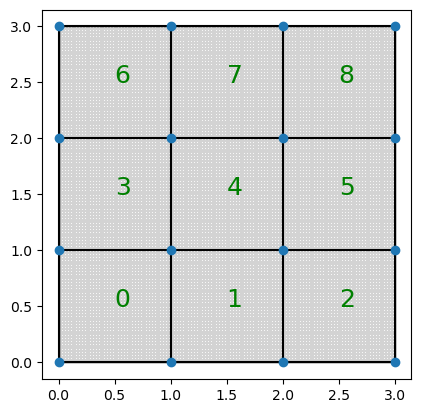

In [49]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
deg=2
elim=False

for N in (40,):
    #patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.unit_square())]
    M = checkerboard(deg,N,0)
    #M.h_refine({0:0})
    #M.h_refine({0:1})
    #M.h_refine({1:1})
    #M.h_refine({0:None})
    #M.h_refine({0:None})
    #M.h_refine({0:None})
    #M.h_refine({0:None})
    #M.h_refine({3:1})
    #M.h_refine({0:1})
    #M.h_refine({4:0})
    #M.h_refine({4:1})
    #M.h_refine({1:0})
    #M.h_refine({1:0})
    #M.h_refine({1:1})
    #M.h_refine({2:0})
    #M.h_refine({0:1})
    #M.h_refine({0:-1})
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
    I = IetiDP(MP, dir_data = {0:g}, elim=elim)
    I.assemble(f=lambda x,y: 1.)
    #print(I.rhsk)
    #print(I.Ak)
    I.construct_primal_constraints()
    I.construct_primal_basis()
    F,b= I.compute_F()
    MsD = I.MsD(pseudo=False)
    ### Solve the system with PCG
    lam, it, cond, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)

In [17]:
b

<32x10 MatrixLinearOperator with dtype=float64>

In [8]:
I.B

<56x532 sparse matrix of type '<class 'numpy.float64'>'
	with 112 stored elements in Compressed Sparse Row format>

setting up constraints took 0.09170770645141602 seconds.
Basis setup took 0.017109155654907227 seconds


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

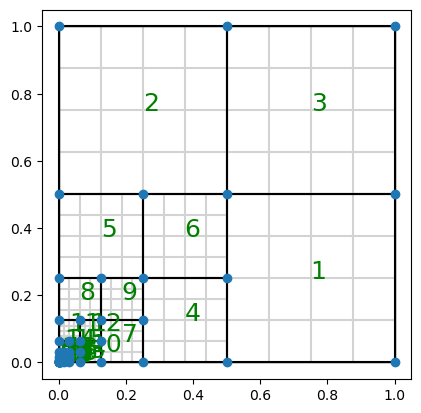

In [6]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
deg=5
elim=True

for N in (4,8,16,32,64):
    #patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.unit_square())]
    M = Lshape(deg,N)
    #M.h_refine({0:0})
    #M.h_refine({0:1})
    #M.h_refine({1:1})
    #M.h_refine({0:None})
    #M.h_refine({0:None})
    #M.h_refine({0:None})
    #M.h_refine({0:None})
    #M.h_refine({3:1})
    #M.h_refine({0:1})
    #M.h_refine({4:0})
    #M.h_refine({4:1})
    #M.h_refine({1:0})
    #M.h_refine({1:0})
    #M.h_refine({1:1})
    #M.h_refine({2:0})
    #M.h_refine({0:1})
    #M.h_refine({0:-1})
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    I = ieti.IetiDP(MP, dir_data = {0:g}, elim=elim)
    MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
    I.assemble(f=lambda x,y: 1.)
    I.construct_primal_constraints()
    I.construct_primal_basis()
    F,b= I.compute_F()
    MsD = I.MsD(pseudo=False)
    ### Solve the system with PCG
    lam, it, cond, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-6)

In [46]:
B = np.linalg.pinv(I.B_gamma.T@I.B_gamma.A)

In [57]:
spy(D)

NameError: name 'D' is not defined

In [71]:
Fmat = F.dot(np.eye(F.shape[0]))

In [73]:
algebra.condest(MsD@Fmat)

5.271205380497244

#####################################
setting up constraints took 0.018363237380981445 seconds.
Basis setup took 0.009409666061401367 seconds
4
10
pcg with preconditioned condition number 1.1104232399228329 stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00043201446533203125 seconds for 9 patches.
setting up constraints took 0.020048141479492188 seconds.
Basis setup took 0.009725570678710938 seconds
7
26
pcg with preconditioned condition number 1.242827242377967 stopped after 6 iterations with relres 9.877262513024327e-15
Refinement took 0.000331878662109375 seconds for 9 patches.
setting up constraints took 0.023079395294189453 seconds.
Basis setup took 0.01008152961730957 seconds
8
23
pcg with preconditioned condition number 1.3131180431114824 stopped after 6 iterations with relres 7.19027091678448e-11
Refinement took 0.0003571510314941406 seconds for 9 patches.
setting up constraints took 0.029850244522094727 seconds.
Basis setup took 0.01311326026916

/home/wolfman/anaconda3/lib/python3.9/site-packages/pyiga-0.1.0-py3.9-linux-x86_64.egg/pyiga/topology.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=kwargs.get('figsize'))


21
25
pcg with preconditioned condition number 1.769266987585349 stopped after 11 iterations with relres 2.2424118613517237e-11
Refinement took 0.0003402233123779297 seconds for 9 patches.
setting up constraints took 0.03714632987976074 seconds.
Basis setup took 0.018062114715576172 seconds
24
24
pcg with preconditioned condition number 1.7675684065257513 stopped after 11 iterations with relres 8.781202012645705e-11
Refinement took 0.00039577484130859375 seconds for 9 patches.
setting up constraints took 0.06232929229736328 seconds.
Basis setup took 0.034009695053100586 seconds
25
24
pcg with preconditioned condition number 1.7590407403296329 stopped after 12 iterations with relres 2.639155553047284e-11
Refinement took 0.00043511390686035156 seconds for 9 patches.
setting up constraints took 0.11404061317443848 seconds.
Basis setup took 0.09270548820495605 seconds


KeyboardInterrupt: 

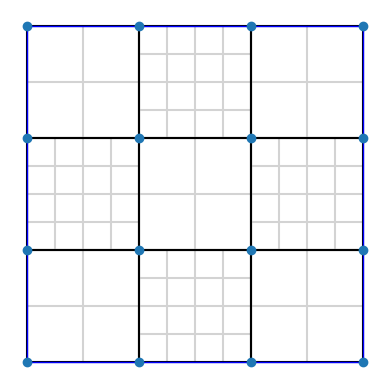

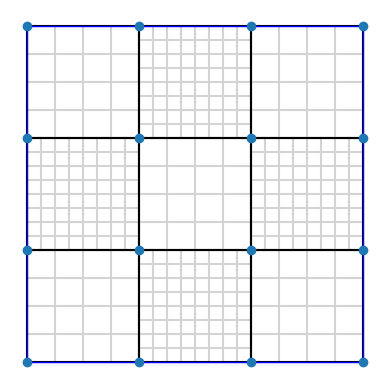

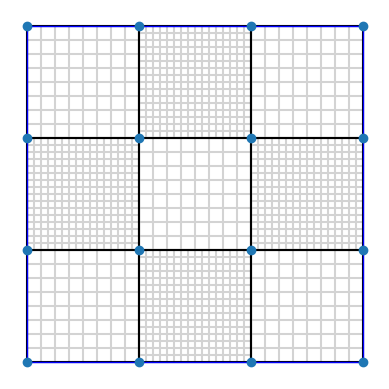

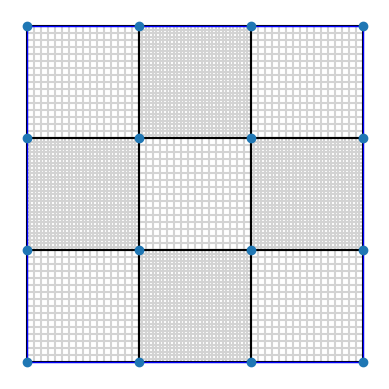

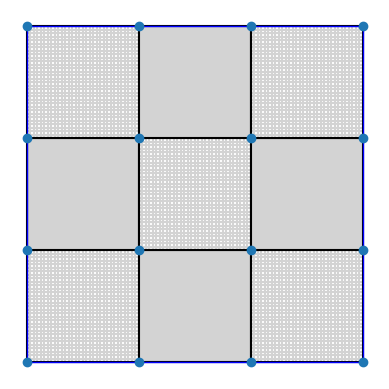

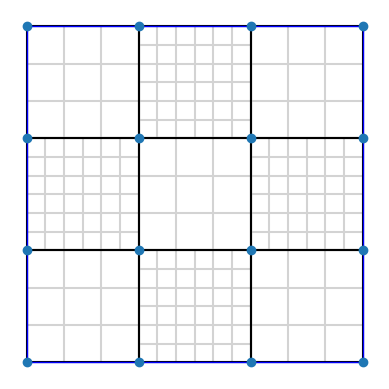

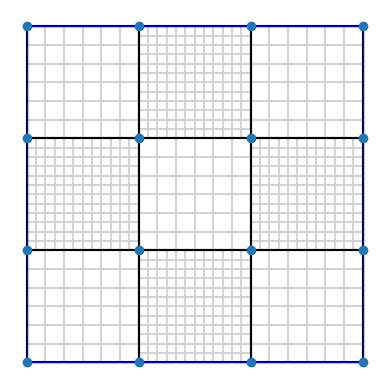

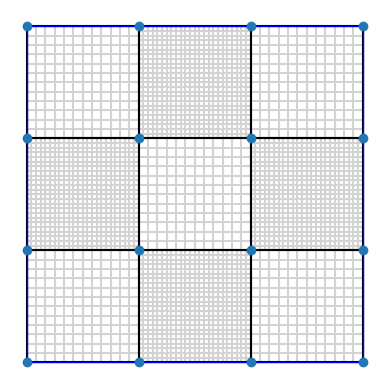

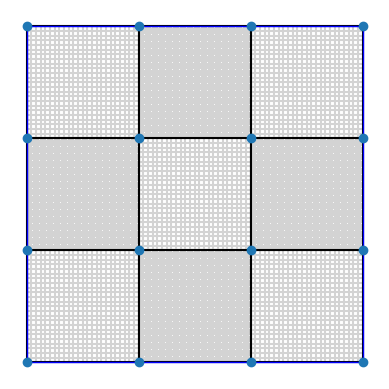

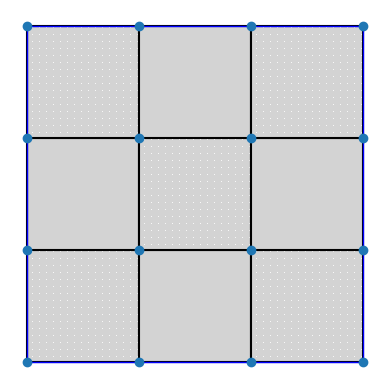

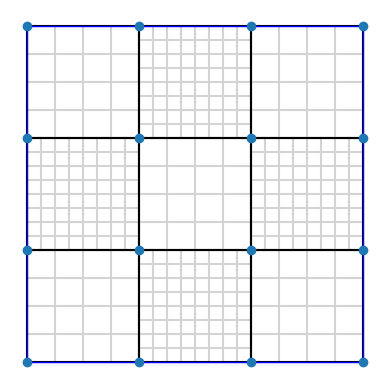

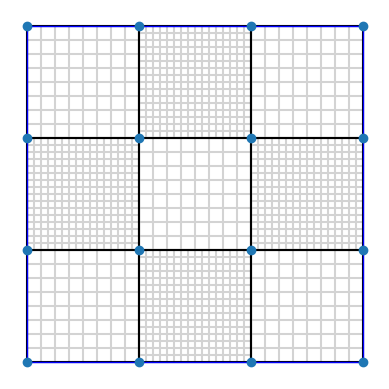

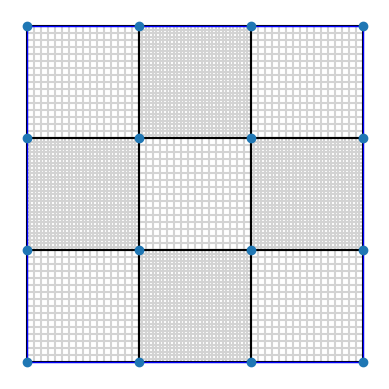

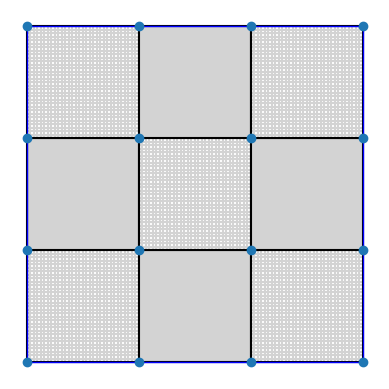

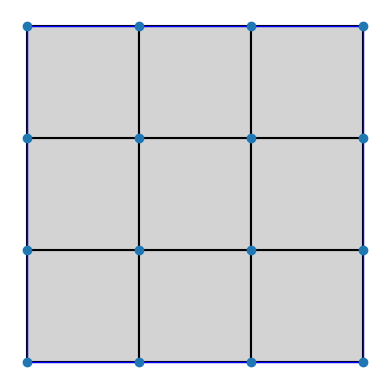

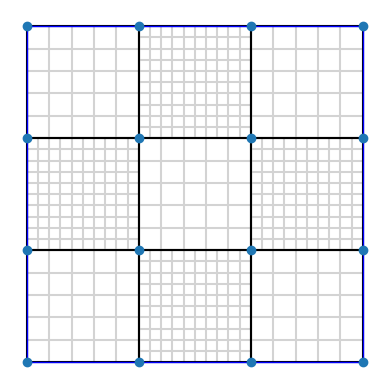

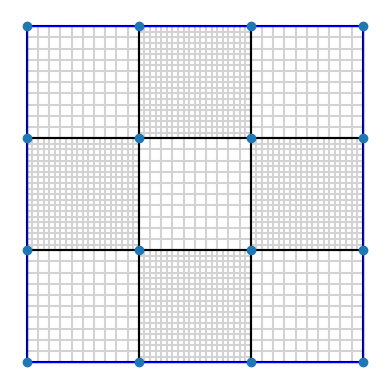

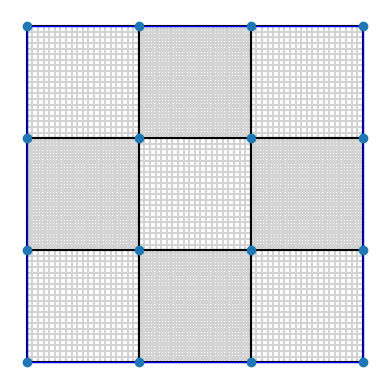

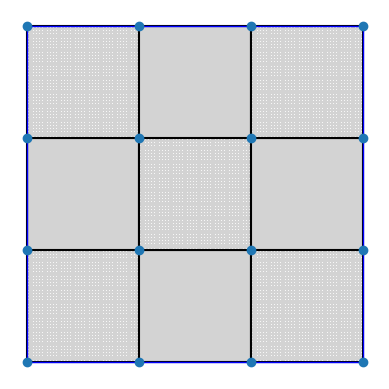

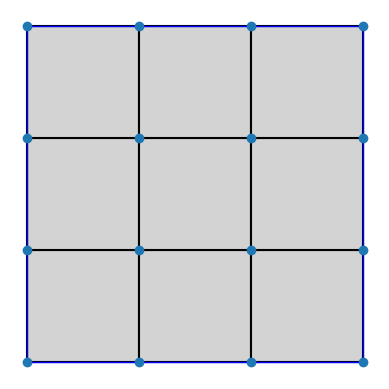

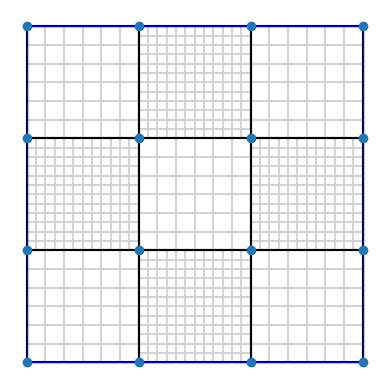

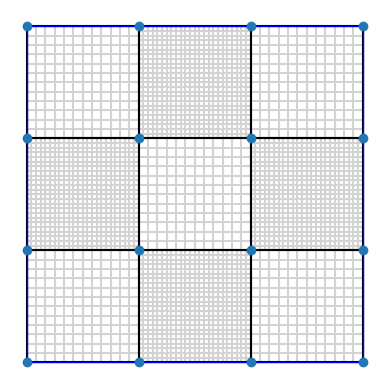

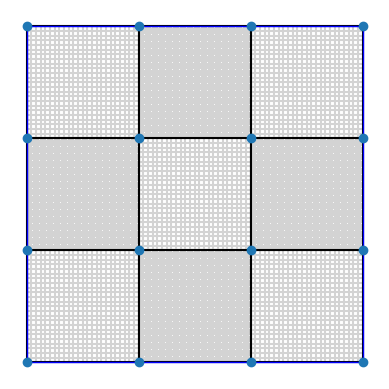

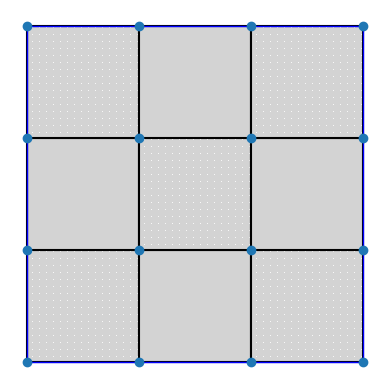

In [16]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = ieti.IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=True)
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.017437458038330078 seconds.
Basis setup took 0.009253501892089844 seconds
pcg stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00016951560974121094 seconds for 4 patches.
setting up constraints took 0.01792740821838379 seconds.
Basis setup took 0.00933218002319336 seconds
pcg stopped after 4 iterations with relres 4.273988115438311e-17
Refinement took 0.0001652240753173828 seconds for 4 patches.
setting up constraints took 0.019681930541992188 seconds.
Basis setup took 0.009746074676513672 seconds
pcg stopped after 4 iterations with relres 9.358588499822341e-15
Refinement took 0.00015854835510253906 seconds for 4 patches.
setting up constraints took 0.021558284759521484 seconds.
Basis setup took 0.011844396591186523 seconds
pcg stopped after 4 iterations with relres 4.58228236822898e-13
Refinement took 0.00017547607421875 seconds for 4 patches.
setting up constraints took 0.02753949165344

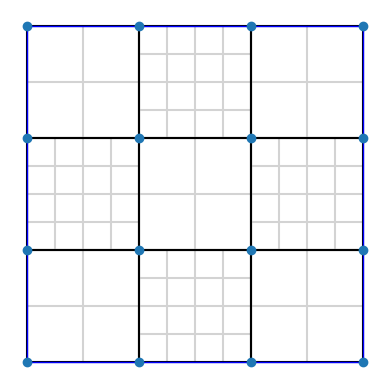

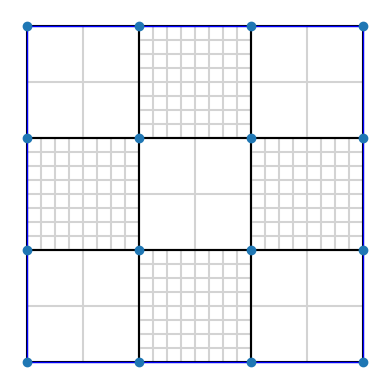

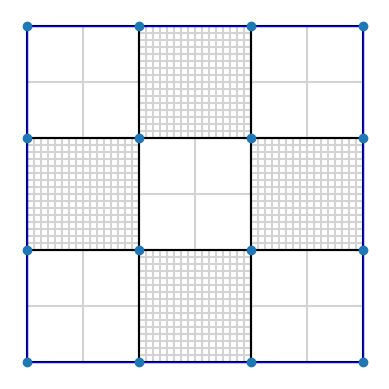

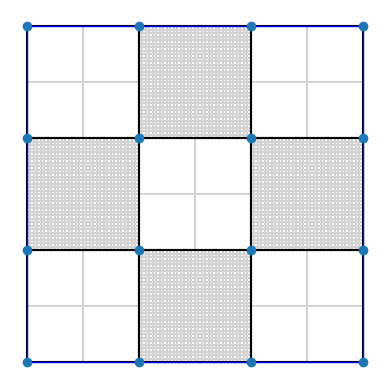

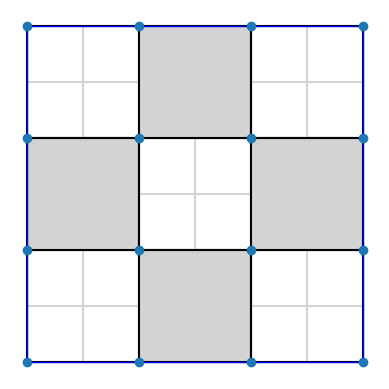

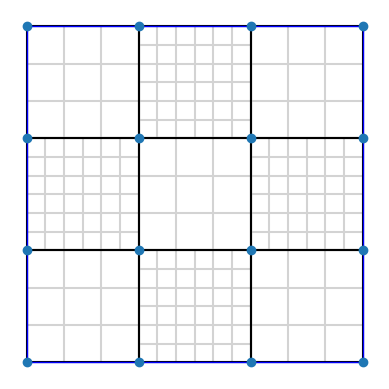

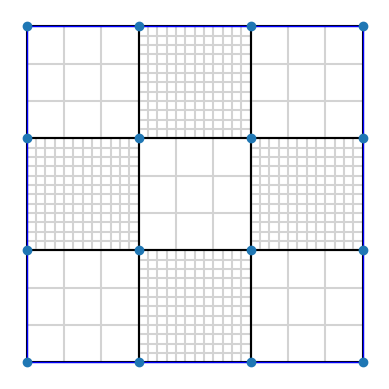

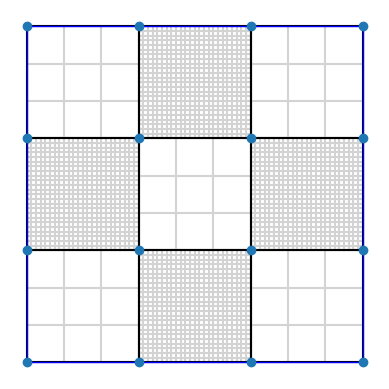

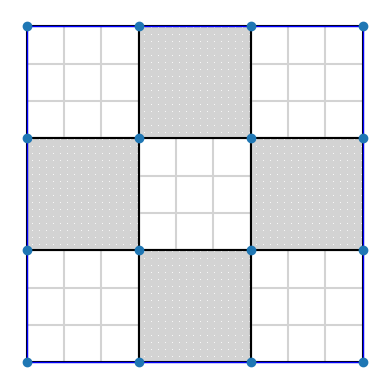

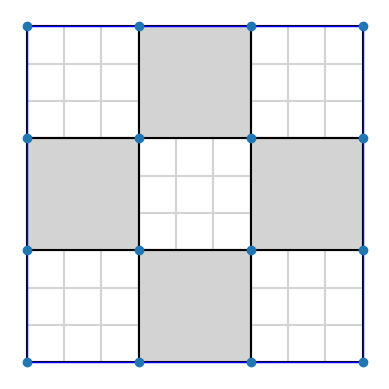

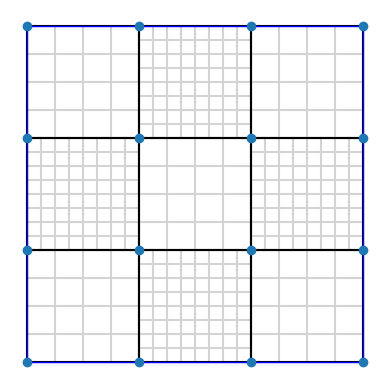

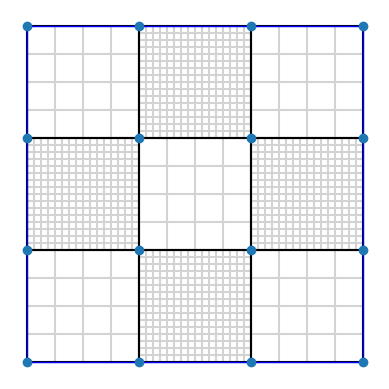

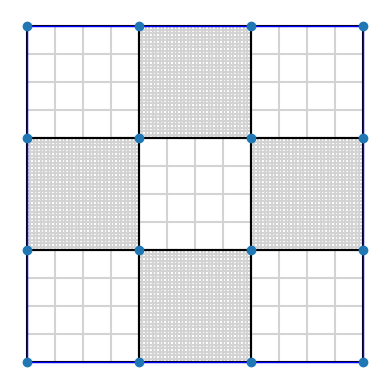

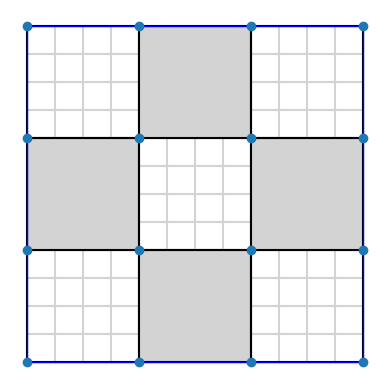

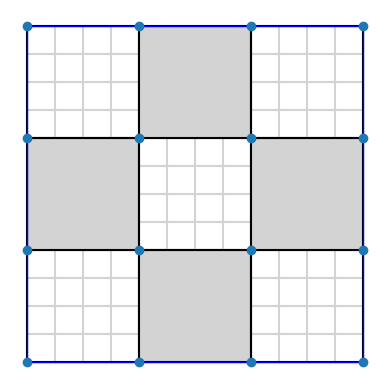

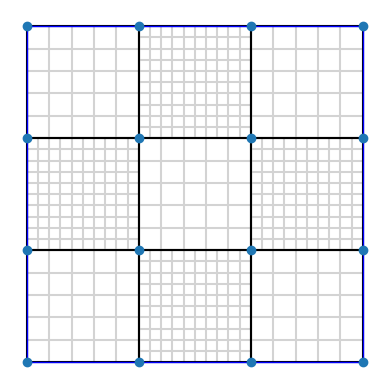

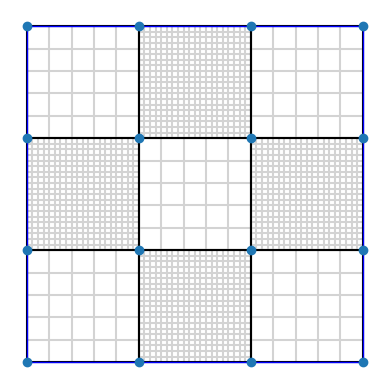

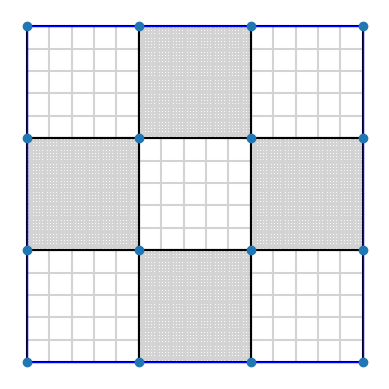

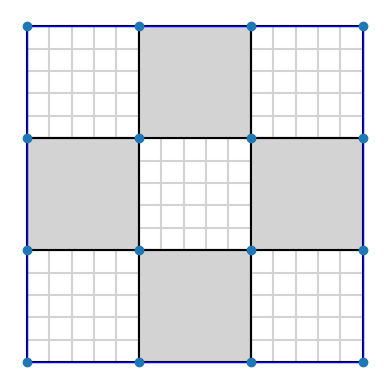

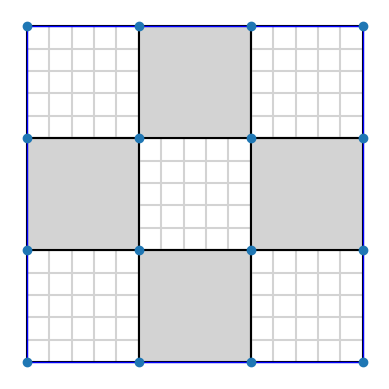

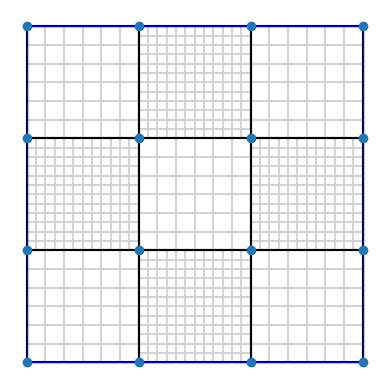

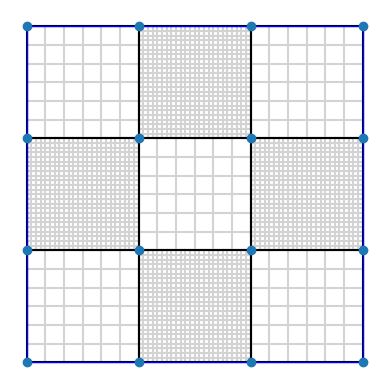

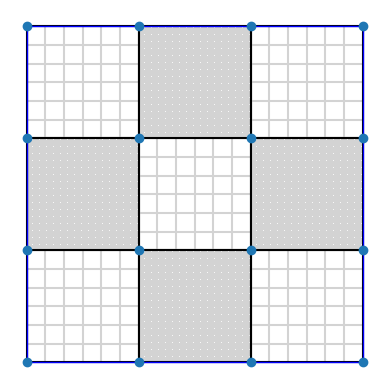

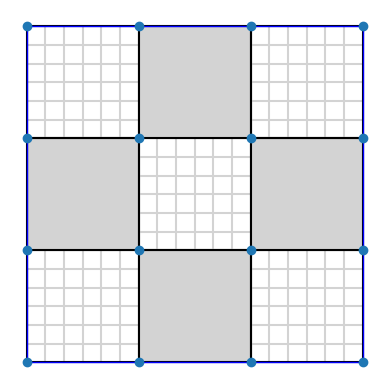

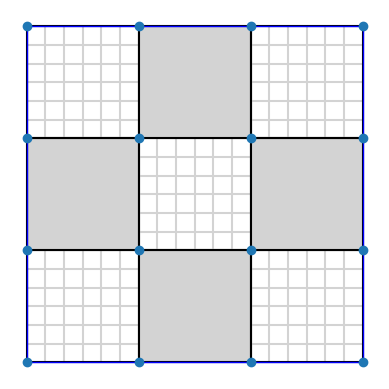

In [49]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = ieti.IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD()
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        ###MP.h_refine(-1)
        MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

In [40]:
it

array([[1., 4., 4., 0., 0., 0.],
       [4., 6., 6., 0., 0., 0.],
       [5., 6., 7., 0., 0., 0.],
       [6., 7., 9., 0., 0., 0.],
       [7., 9., 9., 0., 0., 0.]])

#####################################
setting up constraints took 0.08045482635498047 seconds.
Basis setup took 0.013326406478881836 seconds
pcg stopped after 5 iterations with relres 1.1943491828125505e-11
Refinement took 0.0008785724639892578 seconds for 31 patches.
setting up constraints took 0.07529306411743164 seconds.
Basis setup took 0.013254642486572266 seconds
pcg stopped after 10 iterations with relres 7.11334779789892e-11
Refinement took 0.0022296905517578125 seconds for 31 patches.
setting up constraints took 0.08278107643127441 seconds.
Basis setup took 0.015090227127075195 seconds
pcg stopped after 13 iterations with relres 6.08599090514187e-11
Refinement took 0.0009520053863525391 seconds for 31 patches.
setting up constraints took 0.10501217842102051 seconds.
Basis setup took 0.02293705940246582 seconds
pcg stopped after 15 iterations with relres 7.417342841932e-11
Refinement took 0.0009922981262207031 seconds for 31 patches.
setting up constraints took 0.11850690841674

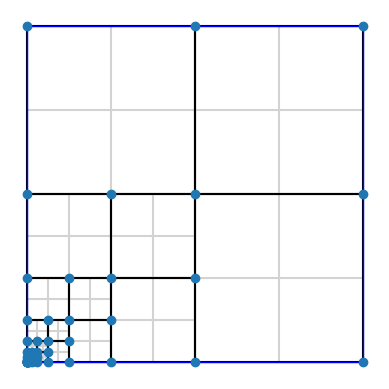

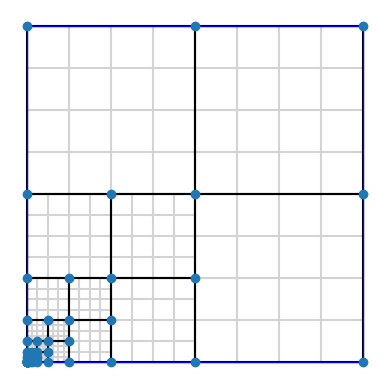

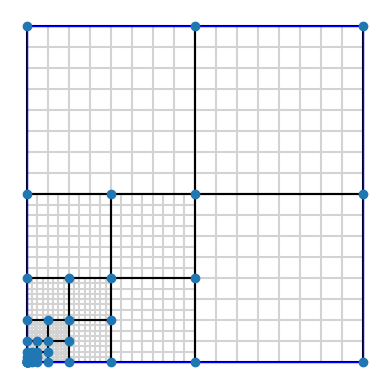

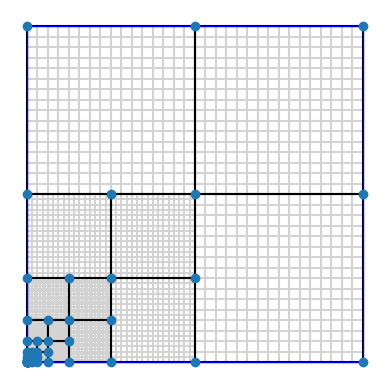

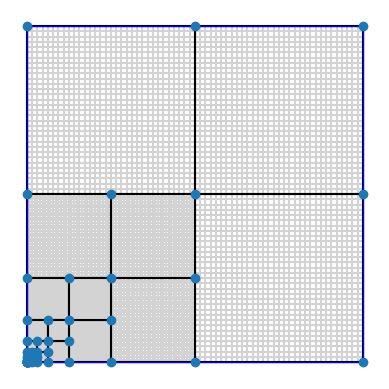

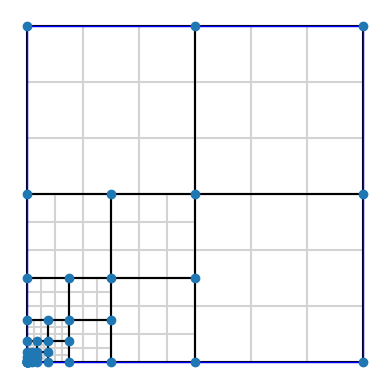

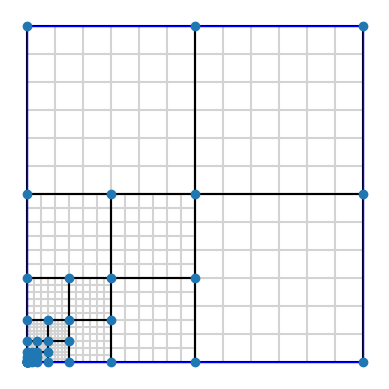

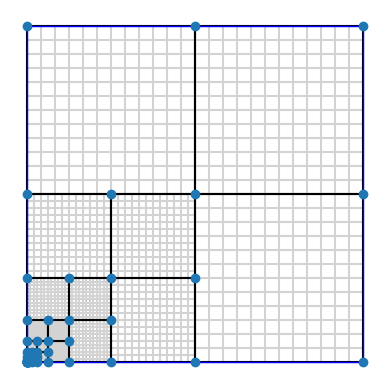

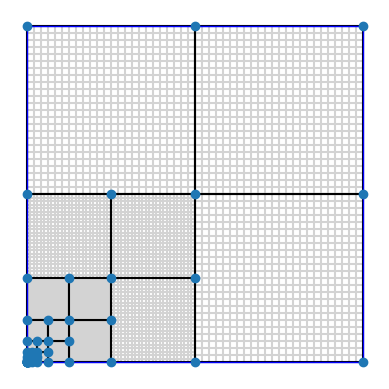

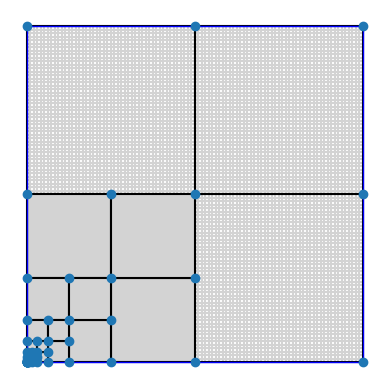

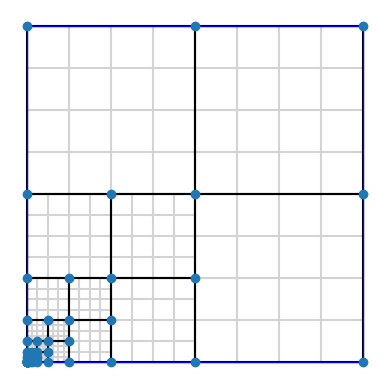

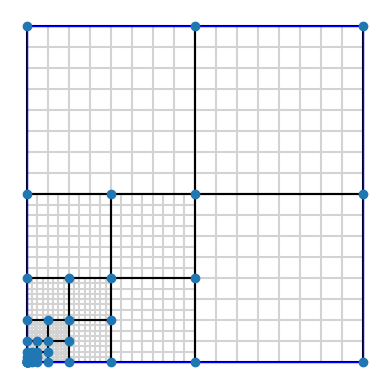

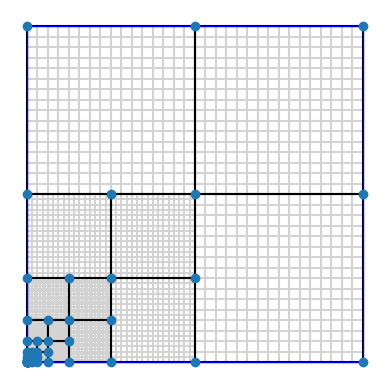

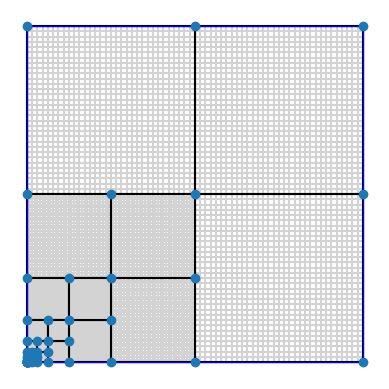

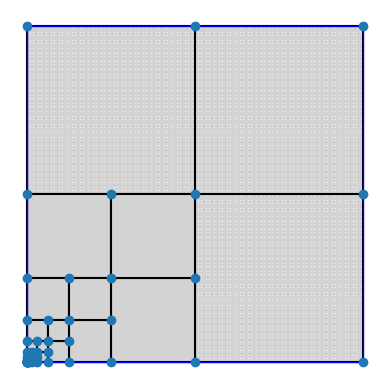

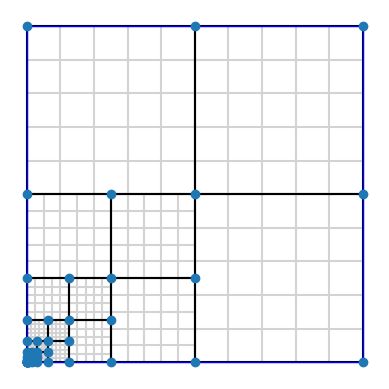

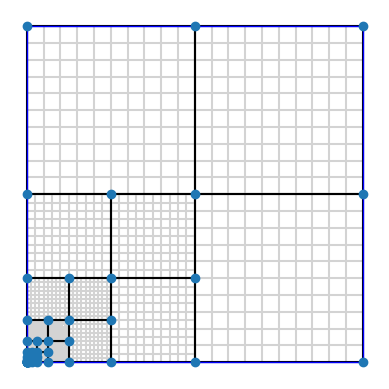

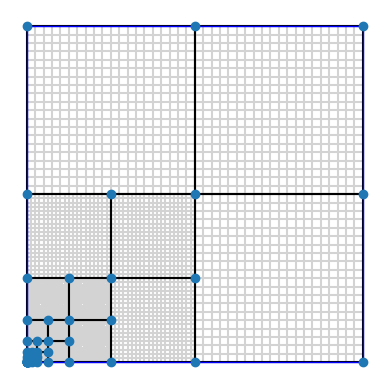

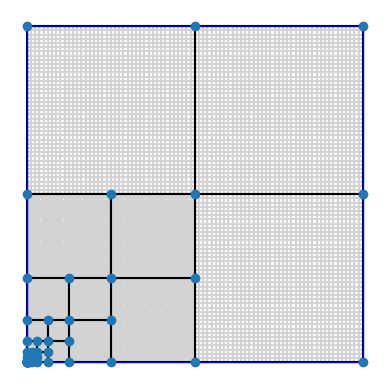

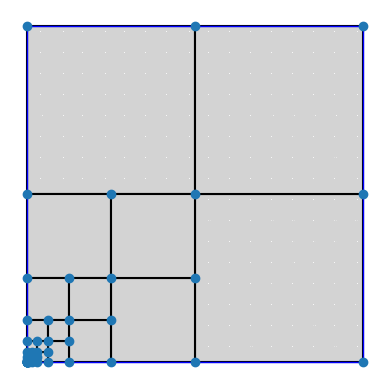

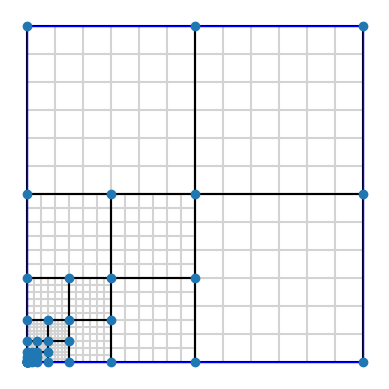

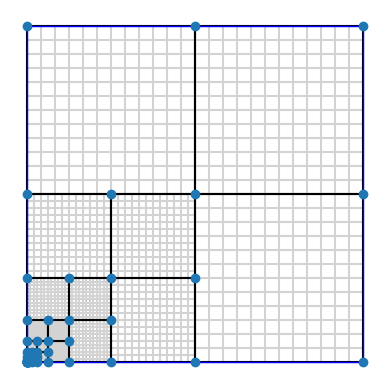

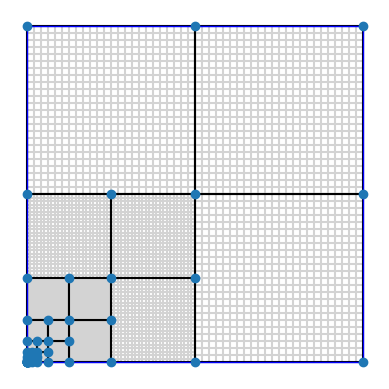

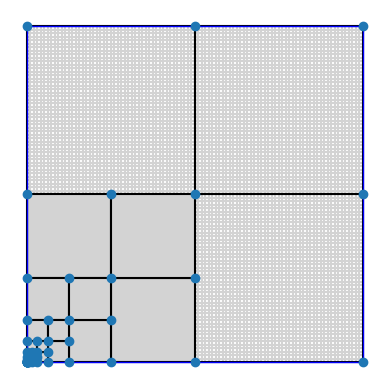

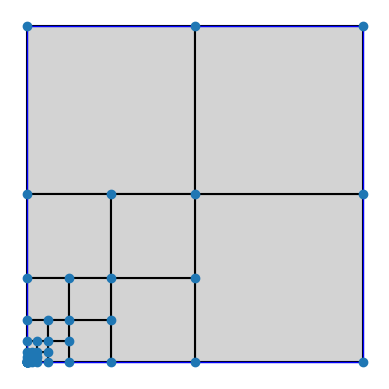

In [55]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=True

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = Lshape(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = ieti.IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD()
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

In [ ]:
topology.PatchMesh(patches).h_refine

In [161]:
I = ieti.IetiDP(MP, dir_data = {0:g}, elim=True)
I.assemble(f=lambda x,y: 1.)
I.construct_primal_constraints()
I.construct_primal_basis()

In [167]:
MP.set_dirichlet_boundary({0:g})

In [168]:
MP.get_nodes()

{24: [array([ 24,  97, 139, 212], dtype=int32)],
 101: [array([105, 126, 216, 237], dtype=int32)],
 180: [array([211, 232, 322, 343], dtype=int32)],
 320: [array([236, 309, 351, 424], dtype=int32)]}

In [12]:
F,b= I.compute_F()

In [13]:
MsD = I.MsD()

In [17]:
### Solve the system with PCG
lam, it, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)

pcg stopped after 4 iterations with relres 1.8569138288326905e-11


setting up constraints took 0.014958620071411133 seconds.
Basis setup took 0.004828929901123047 seconds


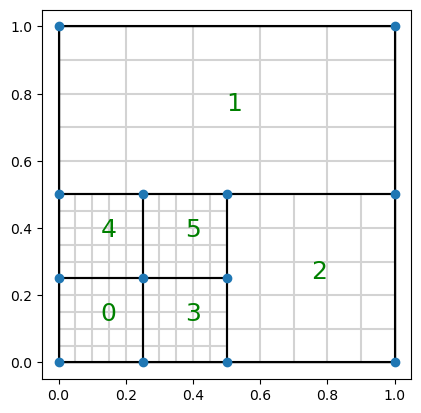

In [172]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
deg=1

patches = [(2*(bspline.make_knots(deg,0.0,1.0,5),),geometry.unit_square())]
M = topology.PatchMesh(patches)
M.h_refine({0:0})
M.h_refine({0:1})
M.h_refine({0:None})
#M.h_refine({0:None})
#M.h_refine({0:None})
#M.h_refine({3:1})
#M.h_refine({0:1})
#M.h_refine({4:0})
#M.h_refine({4:1})
#M.h_refine({1:0})
#M.h_refine({1:0})
#M.h_refine({1:1})
#M.h_refine({2:0})
#M.h_refine({0:1})
#M.h_refine({0:-1})
MP = assemble.Multipatch(M, automatch=True)
MP.set_dirichlet_boundary({0:g})
I = ieti.IetiDP(MP, dir_data = {0:g}, elim=False)
MP.mesh.draw(patch_idx=1,nodes=1,knots=1)

In [173]:
I.assemble(f=lambda x,y: 1.)
I.construct_primal_constraints()
I.construct_primal_basis()

UnboundLocalError: local variable 'Nodes' referenced before assignment

In [159]:
F,b= I.compute_F()

In [160]:
MsD = I.MsD()

In [161]:
Fmat = F.dot(np.eye(F.shape[0]))

In [163]:
algebra.condest(MsD@Fmat)

78.69684561969639

In [164]:
I.B_gamma

<706x1532 sparse matrix of type '<class 'numpy.float64'>'
	with 1412 stored elements in Compressed Sparse Row format>

In [165]:
I.D

<1532x1532 sparse matrix of type '<class 'numpy.float64'>'
	with 1532 stored elements in Compressed Sparse Row format>

In [166]:
np.linalg.norm((I.B_gamma@I.D@I.B_gamma.T-scipy.sparse.identity(I.B_gamma.shape[0])).data)

0.0

In [168]:
### Solve the system with PCG
lam, it, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=1, tol=1e-10)

pcg stopped after 51 iterations with relres 8.484517229926949e-11


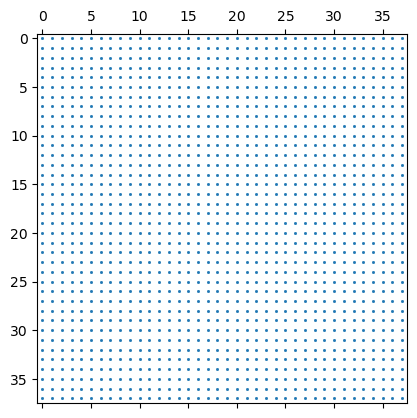

In [15]:
spy(F.dot(np.eye(F.shape[0])),markersize=1)

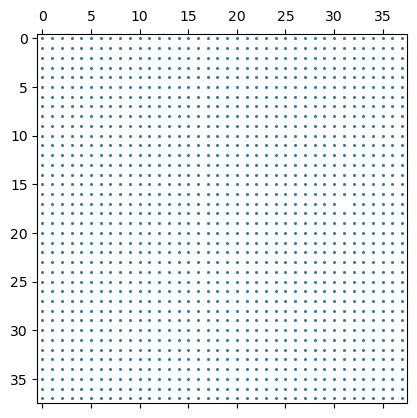

In [16]:
spy(MsD.dot(np.eye(MsD.shape[0])),markersize=1)

In [216]:
np.array(list(I.tpp[0].keys()))

array([], dtype=float64)

In [12]:
np.concatenate([I.cpp[0][1],np.array(list(I.tpp[0].keys()))])

array([0, 2])

In [14]:
Nodes = {i:val for i,val in enumerate(MP.get_nodes().values())}

In [15]:
Nodes

{0: [array([15, 67]), array([36, 40], dtype=int32)],
 1: [array([44, 79]), array([17, 18], dtype=int32)],
 2: [array([51, 64]), array([13, 14], dtype=int32)],
 3: [array([63, 76]), array([16, 17, 18], dtype=int32)]}

In [17]:
I.cpp

{0: (array([15]), array([0])),
 1: (array([], dtype=int64), array([], dtype=int64)),
 2: (array([44]), array([1])),
 3: (array([51, 63]), array([2, 3])),
 4: (array([67, 79, 64, 76]), array([0, 1, 2, 3]))}

In [16]:
I.tpp

{0: {2: [array([51, 64]), array([13, 14], dtype=int32)]},
 1: {1: [array([44, 79]), array([17, 18], dtype=int32)],
  3: [array([63, 76]), array([16, 17, 18], dtype=int32)]},
 2: {0: [array([15, 67]), array([36, 40], dtype=int32)]},
 3: {},
 4: {}}

In [20]:
np.array(list(I.tpp[1].keys()))

array([1, 3])

In [15]:
I.tpp[0]

{(10, 11): [array([51, 64]), array([13, 14], dtype=int32)]}

In [74]:
loc_c = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True)+MP.N_ofs[p] for p, kvs in enumerate(MP.mesh.kvs)])
i_loc_c = np.setdiff1d(loc_c, I.global_dir_idx)

B = MP.Basis[i_loc_c,:]
C_dofs = np.unique(B[B.getnnz(axis=1)==1].indices)
X = scipy.sparse.coo_matrix(MP.Basis)
idx = np.where(np.isclose(X.data,1))
X.data, X.row, X.col = X.data[idx], X.row[idx], X.col[idx]
X = X.tocsc()
Nodes = {c:[X[:,c].indices] for c in C_dofs}
t_idx = i_loc_c[np.where(B.getnnz(axis=1)>1)[0]]
T_dofs = {}
for i in t_idx:
    t = tuple(MP.Basis[i,:].indices)
    coeff = tuple()
    if t not in T_dofs:
        T_dofs[t] = [(i,),set(MP.Constr[MP.Constr.tocsc()[:,i].indices,:].indices)-{i}]
    else:
        T_dofs[t][0] = T_dofs[t][0]+(i,)
        T_dofs[t][1] = T_dofs[t][1] & (set(MP.Constr[MP.Constr.tocsc()[:,i].indices,:].indices)-{i})
T_dofs = {t:[np.sort(T_dofs[t][0]),np.sort(list(T_dofs[t][1]))] for t in T_dofs}
Nodes.update(T_dofs)

In [75]:
MP.get_nodes()

{(32, 36): [array([15, 67]), array([36, 40], dtype=int32)],
 (13, 14): [array([44, 79]), array([17, 18], dtype=int32)],
 (10, 11): [array([51, 64]), array([13, 14], dtype=int32)],
 (12, 13, 14): [array([63, 76]), array([16, 17, 18], dtype=int32)]}

In [76]:
loc_c_prim = np.concatenate([Nodes[key][0] for key in Nodes])
cpp = {p : loc_c_prim[(loc_c_prim >= MP.N_ofs[p]) & (loc_c_prim < MP.N_ofs[p+1])] for p in range(MP.numpatches)}
tpp = {p : {key:val for key,val in Nodes.items() if isinstance(key,tuple) and all((val[1] >= MP.N_ofs[p]) & (val[1] < MP.N_ofs[p+1]))} for p in range(MP.numpatches)}

In [79]:
tpp[0]

{(10, 11): [array([51, 64]), array([13, 14], dtype=int32)]}

In [113]:
p=0
V = []
for t in tpp[p]:
    constr = (MP.Constr.tocsc()[:,tpp[p][t][0][0]]==1).indices
    V.append(MP.Constr[constr,:][:,MP.N_ofs[p]:MP.N_ofs[p+1]])
Ck = scipy.sparse.vstack(V)

In [114]:
[I.Ck[0]]+V

[<1x9 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>,
 <1x16 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>]

In [112]:
scipy.sparse.vstack([I.Ck[0]]+V)

ValueError: blocks[:,0] has incompatible column dimensions. Got blocks[1,0].shape[1] == 16, expected 9.

In [117]:
loc_t = Nodes[(12,13,14)]

In [118]:
loc_t

array([16, 17, 18, 63, 94], dtype=int32)

In [119]:
coarse_dofs = loc_t[MP.Basis[loc_t,:].getnnz(axis=1)==1]
fine_dofs = loc_t[MP.Basis[loc_t,:].getnnz(axis=1)>1]

In [120]:
coarse_dofs, fine_dofs

(array([16, 17, 18], dtype=int32), array([63, 94], dtype=int32))

In [145]:
constr = (MP.Constr.tocsc()[:,fine_dofs[0]]==1).indices
MP.Constr[constr,:][:,MP.N_ofs[p]:MP.N_ofs[p+1]]

In [146]:
constr

array([3], dtype=int32)

In [147]:
print(MP.Constr[constr,:][:,MP.N_ofs[1]:MP.N_ofs[2]])

  (0, 0)	-0.25
  (0, 1)	-0.625
  (0, 2)	-0.125


In [121]:
MP.Constr.tocsc()[:,fine_dofs].indices

array([ 3, 16, 17, 17, 18], dtype=int32)

In [124]:
print(MP.Constr[23,:][:,MP.N_ofs[1]:MP.N_ofs[2]].A)

[[ 0.  -0.5 -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]


In [ ]:
print(MP.Constr

In [65]:
loc_prim = np.unique(np.concatenate(list(Nodes.values())))
cpp = {p : loc_prim[(loc_prim >= MP.N_ofs[p]) & (loc_prim < MP.N_ofs[p+1])] for p in range(MP.numpatches)}

In [27]:
print(MP.Basis[9,:])

  (0, 6)	1.0


In [66]:
loc_prim = {p : {key : val[(val >= MP.N_ofs[p]) & (val < MP.N_ofs[p+1])] for key,val in Nodes.items() if any((val >= MP.N_ofs[p]) & (val < MP.N_ofs[p+1]))} for p in range(MP.numpatches)}

In [76]:
loc_prim[1]

{7: array([10], dtype=int32), (6, 7): array([ 9, 10], dtype=int32)}

In [71]:
MP.Constr[:,loc_prim[1][7]].A

array([[ 0.  ],
       [-0.25],
       [-0.5 ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [-0.5 ],
       [-0.75],
       [-1.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [-1.  ],
       [-0.5 ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ]])

In [50]:
cpp = {p : {key : val for key,val in Nodes.items() if len(np.intersect1d(val, np.arange(MP.N_ofs[p],MP.N_ofs[p+1]))) > 0} for p in range(MP.numpatches)}

In [52]:
cpp[4]

{5: array([ 7, 29, 36], dtype=int32),
 7: array([10, 24, 44], dtype=int32),
 18: array([ 8, 21, 38], dtype=int32),
 (6, 7): array([ 9, 10, 35, 42], dtype=int32)}

In [91]:
print(MP.Constr[MP.Constr.tocsc()[:,np.array([35])].indices,:])

  (0, 35)	1.0
  (0, 10)	-0.5
  (0, 33)	-0.5
  (1, 35)	1.0
  (1, 42)	-1.0


In [136]:
T_dofs = {}
for i in i_loc_c:
    t = tuple(MP.Basis[i,:].indices)
    if t not in T_dofs:
        T_dofs[t] = {i}
    else:
        T_dofs[t].add(i)
        
T_dofs = {t:np.array(list(T_dofs[t])) for t in T_dofs}

In [82]:
MP.Constr[:,i_loc_c]

<10x4 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [87]:
MP.Basis.tocsc()[:,5]

<16x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Column format>

In [96]:
rows=np.unique(MP.Constr.tocsc()[:,i_loc_c].indices)

In [97]:
MP.Constr[rows,:].A

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.75, -0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.5 , -0.5 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.25, -0.75,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.5 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  , -0.5 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [99]:
B, _ = algebra.compute_basis(MP.Constr[rows,:], maxiter=5)

In [101]:
B.A

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.

In [61]:
C_dofs

array([16], dtype=int32)

In [66]:
MP.Basis[:,16].A

array([[0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [1.  ],
       [0.  ],
       [0.  ],
       [0.25],
       [0.5 ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [1.  ],
       [0.5 ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.5 ],
       [0.75],
       [1.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ]])

In [42]:
def sp_unique(sp_matrix, axis=0):
    ''' Returns a sparse matrix with the unique rows (axis=0)
    or columns (axis=1) of an input sparse matrix sp_matrix'''
    if axis == 1:
        sp_matrix = sp_matrix.T

    old_format = sp_matrix.getformat()
    dt = np.dtype(sp_matrix)
    ncols = sp_matrix.shape[1]

    if old_format != 'lil':
        sp_matrix = sp_matrix.tolil()

    _, ind = np.unique(sp_matrix.data + sp_matrix.rows, return_index=True)
    rows = sp_matrix.rows[ind]
    data = sp_matrix.data[ind]
    nrows_uniq = data.shape[0]

    sp_matrix = scipy.sparse.lil_matrix((nrows_uniq, ncols), dtype=dt)  #  or sp_matrix.resize(nrows_uniq, ncols)
    sp_matrix.data = data
    sp_matrix.rows = rows

    ret = sp_matrix.asformat(old_format)
    if axis == 1:
        ret = ret.T        
    return ret

In [50]:
def lexsort_row(A):
    ''' numpy lexsort of the rows, not used in sp_unique'''
    return A[np.lexsort(A.T[::-1])]

In [54]:
A = 10*scipy.sparse.random(100000, 3, 0.5, format='csr')
#A = np.ceil(A).astype(int)

    # unique rows
A_uniq = sp_unique(A, axis=0).toarray()
A_uniq = lexsort_row(A_uniq)
A_uniq_numpy = np.unique(A.toarray(), axis=0)
assert (A_uniq == A_uniq_numpy).all()

    # unique columns
A_uniq = sp_unique(A, axis=1).toarray()
A_uniq = lexsort_row(A_uniq.T).T
A_uniq_numpy = np.unique(A.toarray(), axis=1)
assert (A_uniq == A_uniq_numpy).all()  

In [43]:
MP.Basis.A[5,:]

array([0.  , 0.  , 0.75, 0.  , 0.25, 0.  , 0.  , 0.  ])

In [44]:
S = scipy.sparse.csr_matrix(np.array([[0,0,1],[0,0,1]]))

In [46]:
sp_unique(S).A

array([[0, 0, 1]])

In [98]:
B.getnnz(axis=1)>1

array([ True, False,  True, False, False, False])

In [95]:
B

<6x29 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [85]:
MP.Basis[:,T_dofs[0]].sum(axis=1)

matrix([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [103]:
MP.Basis[:,18].tocsc().indices

array([ 8, 15, 29, 36], dtype=int32)

In [79]:
B.indices

array([18, 18, 23, 23, 18, 35, 18, 23, 35, 22, 23, 22, 35, 35, 22, 22], dtype=int32)

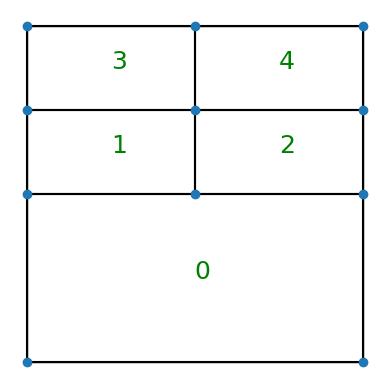

In [99]:
MP.mesh.draw(knots=1,nodes=1,patch_idx=1)
axis('off');

In [116]:
#kvs_ = MP.mesh.kvs
geos = MP.mesh.geos
kvs = MP.mesh.kvs
idx=[]
vals=[]
for key in MP.mesh.outer_boundaries:
    for p,b in MP.mesh.outer_boundaries[key]:
        idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p],geos[p],[(b//2,b%2)],lambda x,y : 1.)
        idx.append(idx_+MP.N_ofs[p])
        vals.append(vals_)
        
uidx, lookup = np.unique(idx, return_index=True)
#vals = np.concatenate(vals)
bcs=tuple((uidx,np.concatenate(vals)[lookup]))

cpp = MP.get_crosspoints()

/home/wolfman/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


ValueError: operands could not be broadcast together with shapes (10,) (6,) 

In [10]:
### Linear system assembly and restrictions

# assemble the lhs of the linear system
Ak = [assemble.assemble('inner(grad(u),grad(v)) * dx', kvs, bfuns=[('u',1), ('v',1)], geo=g) for kvs, g in zip(kvs,geos)]
#Ak = [assemble.assemble('inner(grad(grad(u)), grad(grad(v))) * dx', kvs, bfuns=[('u',1), ('v',1)], geo=g) for g in geos]
A = scipy.sparse.block_diag(Ak, format='csr')

#print("Rank ", np.linalg.matrix_rank(A.A), " vs. shape ", A.shape)


# Assemble the rhs of the linear system 
rhs = [assemble.assemble('f * v * dx', kvs, params, bfuns=[('v',1)], geo=g, f=lambda x,y: 1.).ravel() for kvs, g in zip(kvs,geos)]
# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
N = MP.Basis@MP.assemble_surface('g1 * inner(grad(v),n) * ds', arity=1, g1=g, boundary_idx=0)
rhs = np.hstack(rhs) + N

# Eliminate Dirichlet dofs
BCRestr = assemble.RestrictedLinearSystem(A, rhs, bcs)
free_dofs = BCRestr.R_free

# Eliminate the Dirichlet dofs from the interface dofs
nnz_per_col = MP.Constr.getnnz(axis=0)
intf_dofs = np.where(nnz_per_col > 0)[0]
intfs = np.setdiff1d(intf_dofs, bcs[0])

# Patchwise restrictions
"""
Akii = []
Akbb = []
Akbi = []
bnd_dofs = np.concatenate([indices for indices in assemble.boundary_dofs(kvs)])
for p in range(len(MP.mesh.patches)):
    I = scipy.sparse.eye(Ak[p].shape[1], format='csr')
    mask = np.zeros(Ak[p].shape[1], dtype=bool)

    intindices = (intfs < MP.N_ofs[p+1]) & (intfs >= MP.N_ofs[p])
    intindices = intfs[intindices]-MP.N_ofs[p]
    
    mask[intindices] = True
    Rbb = I[mask]
    Akbb.append(Rbb.dot(Ak[p]).dot(Rbb.T)) 
    
    mask = np.ones(Ak[p].shape[1], dtype=bool)
    mask[bnd_dofs] = False
    Rii = I[mask]
    Akii.append(Rii.dot(Ak[p]).dot(Rii.T)) 
    
    Akbi.append(Rbb.dot(Ak[p]).dot(Rii.T))
""" 

# Compute the partial matrices 
Id = scipy.sparse.eye(A.shape[1], format='csr')
mask = np.zeros(A.shape[1], dtype=bool)
mask[list(intfs)] = True
Rbb = Id[mask]
mask = np.ones(A.shape[1], dtype=bool)

for p in range(len(patches)):
    bnd_dofs = np.concatenate([indices for indices in assemble.boundary_dofs(kvs[p])])
    mask[bnd_dofs+MP.N_ofs[p]] = False

Rii = Id[mask]

Abb = Rbb.dot(A).dot(Rbb.T)
Aii = Rii.dot(A).dot(Rii.T)
Abi = Rbb.dot(A).dot(Rii.T)
Aib = Abi.T
#print(Abi.shape)

# The matrices and vectors without the Dirichlet dofs
A = BCRestr.A
rhs = BCRestr.b

#print("Rank ", np.linalg.matrix_rank(A.A), " vs. shape ", A.shape)

assert A.shape[1] == rhs.shape[0], "Size of rhs is different to size of the matrix"

# Other method for assembly
#def bilinear():
#    vf = vform.VForm(2)
#   u, v = vf.basisfuns()
#    vf.add(vform.tr(vform.hess(u)) * vform.tr(vform.hess(v)) * vform.dx)
#    return vf

#a = bilinear()

In [11]:
### Construct the constraint matrix C that immediately eliminates the columns related to Dirichlet conditions
def construct_constraint_matrices():
    eliminate_constraints = np.array([], dtype=int)
    Ck = []
    loc_dirichlet = []
    for p in range(len(MP.mesh.patches)):
        bndindices = (bcs[0] < MP.N_ofs[p+1]) & (bcs[0] >= MP.N_ofs[p])
        to_eliminate = bcs[0][bndindices]-MP.N_ofs[p]
        
        loc, _ = cpp[p][0]
        
        nnz_per_row = MP.Constr[:,loc+MP.N_ofs[p]].getnnz(axis=1)
        result = np.where(nnz_per_row > 0)[0]
        eliminate_constraints = np.union1d(eliminate_constraints, result)
        
        ck = MP.Constr[result,MP.N_ofs[p]:MP.N_ofs[p+1]]
        ck = np.delete(ck.A, 
                       to_eliminate, 
                       axis=1)
                
        q,r = np.linalg.qr(ck.T)
        ck = scipy.sparse.csr_matrix(ck[np.abs(np.diag(r))>=1e-10])
        
        #if p == 3:
        #    print("Ck", result)
        
        Ck.append(ck)
        loc_dirichlet.append(to_eliminate)

    return Ck, scipy.sparse.block_diag(Ck), eliminate_constraints, loc_dirichlet

In [12]:
### Construct the constraint matrix C that immediately eliminates the columns related to Dirichlet conditions
def construct_constraint_matrices2():
    eliminate_constraints = np.array([], dtype=int)
    Ck = []
    loc_dirichlet = []
    for p in range(len(MP.mesh.patches)):
        bndindices = (bcs[0] < MP.N_ofs[p+1]) & (bcs[0] >= MP.N_ofs[p])
        to_eliminate = bcs[0][bndindices]-MP.N_ofs[p]
        free = np.setdiff1d(np.arange(MP.N[p]),to_eliminate)
        primal = assemble.boundary_dofs(kvs, m=0, ravel=1)
        primal_free = np.setdiff1d(primal, to_eliminate)
        
        #loc, _ = cpp[p][0]
        
        data = np.ones(len(primal_free))
        rows = np.arange(len(primal_free))
        cols = primal_free
        ck = coo_matrix((data, (rows, cols)),(len(primal_free),MP.N[p])).tocsc()
        ck = ck[:,free]
        Ck.append(ck)

    return Ck, scipy.sparse.block_diag(Ck), eliminate_constraints, loc_dirichlet

In [13]:
Ck, C, eliminate_rows, loc_dirichlet = construct_constraint_matrices()

In [14]:
def construct_primal_basis(Ak, Ck):
    Psi = []
    for p in range(len(patches)):
        a = Ak[p*Ck[p].shape[1]:(p+1)*Ck[p].shape[1], p*Ck[p].shape[1]:(p+1)*Ck[p].shape[1]]
        c = Ck[p]
        AC = scipy.sparse.bmat(
        [[a, c.T],
         [c,  None   ]], format='csr')
        RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
        psi = scipy.sparse.linalg.spsolve(AC, RHS)
        psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
        if len(psi.shape)==1: psi=psi[None]
        
        Psi.append(psi)
        
    return Psi

In [15]:
Psik=construct_primal_basis(A, Ck)

PSI = scipy.sparse.bmat([[Psik[0], None,    None,    None   ],
                         [None,    Psik[1], None,    None   ],
                         [None,    None,    Psik[2], None   ],
                         [None,    None,    None,    Psik[3]]], format='csr')

In [16]:
# Prepare the jump matrix 
# I.e., eliminate the rows related to corner constraints
B = MP.Constr
B = scipy.sparse.csr_matrix(np.delete(B.A, eliminate_rows, axis=0))
B = B@free_dofs.T

In [17]:
# Get all the matrices
PTAP = PSI@A@PSI.T
PTBT = PSI@B.T
BP   = B@PSI.T

In [18]:
### Set up the linear system
#A_ieti = scipy.sparse.bmat(
#    [[A,    C.T,  None, B.T  ],
#     [C,    None, None, None ],
#     [None, None, PTAP, PTBT ],
#     [B,    None, BP,   None ]], format='csr')

BL = scipy.sparse.bmat([[B,    np.zeros((B.shape[0],C.shape[0])), BP]], format='csr')
BR = scipy.sparse.bmat([[B.T],    
                        [np.zeros((C.shape[0],B.shape[0]))], 
                        [PTBT]], format='csr')
A0 = scipy.sparse.bmat(
    [[A,    C.T,  None],
     [C,    None, None],
     [None, None, PTAP]], format='csr')

print("Rank ", np.linalg.matrix_rank(PTAP.A), " vs. shape ", PTAP.shape)

b = np.hstack((rhs, np.zeros(C.shape[0],), PSI.dot(rhs), np.zeros(B.shape[0],)))

BR = scipy.sparse.linalg.aslinearoperator(BR)
BL = scipy.sparse.linalg.aslinearoperator(BL)
A0inv = solvers.make_solver(A0.A, spd=False)

F = BL@A0inv.dot(BR)

TR = np.hstack((rhs, np.zeros((C.shape[0],)), PSI.dot(rhs)))
b = BL@(A0inv.dot(TR))

"""
A0inv = scipy.sparse.linalg.spsolve(A0, BR.A)
F = BL@A0inv

A0inv = scipy.sparse.linalg.spsolve(A0, TR)
b = BL@A0inv
"""

Rank  4  vs. shape  (4, 4)


'\nA0inv = scipy.sparse.linalg.spsolve(A0, BR.A)\nF = BL@A0inv\n\nA0inv = scipy.sparse.linalg.spsolve(A0, TR)\nb = BL@A0inv\n'

In [19]:
### Dirichlet preconditioner MsD
B_gamma = MP.Constr
B_gamma = scipy.sparse.csr_matrix(np.delete(B_gamma.A, eliminate_rows, axis=0))
B_gamma = B_gamma@Rbb.T

#print(np.linalg.matrix_rank(Rbb.A, 1e-8))
#print(B_gamma.shape)

#Aib = scipy.sparse.linalg.aslinearoperator(Aib)
AiiinvB = scipy.sparse.linalg.spsolve(Aii, Aib.A)
S = Abb - Abi@AiiinvB
D = np.abs(B_gamma).sum(axis=0)
D = [1/(1+D[0,v]) for v in range(D.shape[1])]
D = scipy.sparse.diags(D, format='csr')

BgD = B_gamma@D
MsD = BgD@S@BgD.T    

In [76]:
scipy.sparse.csr_matrix(np.delete(MP.Constr.A, eliminate_rows, axis=0))

<8x36 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [75]:
I.B

<8x36 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [61]:
B_gamma

<8x12 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [52]:
MsD.A

array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.64583,  0.     ,  0.     ,  0.09375,  0.     ,  0.     , -0.09375],
       [ 0.     ,  0.     ,  0.64583,  0.     , -0.09375,  0.     ,  0.     ,  0.09375],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.09375, -0.09375,  0.     ,  0.64583,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     , -0.09375,  0.09375,  0.     ,  0.     ,  0.     ,  0.     ,  0.64583]])

In [30]:
I.eliminate_constraints

array([0, 2, 6, 8])

In [26]:
MsD

matrix([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.64583,  0.     ,  0.     ,  0.09375,  0.     ,  0.     , -0.09375],
        [ 0.     ,  0.     ,  0.64583,  0.     , -0.09375,  0.     ,  0.     ,  0.09375],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.09375, -0.09375,  0.     ,  0.64583,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     , -0.09375,  0.09375,  0.     ,  0.     ,  0.     ,  0.     ,  0.64583]])

In [28]:
I.MsD()

matrix([[ 0.64583,  0.     ,  0.     ,  0.     ,  0.09375,  0.     , -0.09375, -0.05208],
        [ 0.     ,  0.22569, -0.08681,  0.     , -0.05208,  0.     ,  0.03472, -0.06944],
        [ 0.     , -0.08681,  0.64583,  0.     , -0.09375,  0.     ,  0.09375,  0.03472],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.09375, -0.05208, -0.09375,  0.     ,  0.64583,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [-0.09375,  0.03472,  0.09375,  0.     ,  0.     ,  0.     ,  0.64583, -0.08681],
        [-0.05208, -0.06944,  0.03472,  0.     ,  0.     ,  0.     , -0.08681,  0.22569]])

In [44]:
B=MP.Constr

In [48]:
scipy.sparse.csr_matrix(np.delete(B.A, eliminate_rows, axis=0))

<8x36 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [49]:
B_gamma=B[np.setdiff1d(np.arange(B.shape[0]),eliminate_rows),:]

In [42]:
B_gamma@Rbb.T

<8x12 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [43]:
I.B_gamma

<5x12 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [32]:
eliminate_rows

array([ 2,  3,  6, 11])

In [83]:
### Solve the system with PCG
u, it, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD.A, output=1, tol=1e-10)

pcg stopped after 4 iterations with relres 8.5775770503511e-11


In [21]:
F

<8x8 _ProductLinearOperator with dtype=float64>

In [66]:
it

3

In [22]:
MsD

matrix([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.64583,  0.     ,  0.     ,  0.09375,  0.     ,  0.     , -0.09375],
        [ 0.     ,  0.     ,  0.64583,  0.     , -0.09375,  0.     ,  0.     ,  0.09375],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.09375, -0.09375,  0.     ,  0.64583,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     , -0.09375,  0.09375,  0.     ,  0.     ,  0.     ,  0.     ,  0.64583]])

In [26]:
MsD_

matrix([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.64583,  0.     ,  0.     ,  0.09375],
        [ 0.     ,  0.     ,  0.64583,  0.     , -0.09375],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.09375, -0.09375,  0.     ,  0.64583]])